<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import math

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('./capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    files = glob(path_to_csv_files + '/*.csv')
    with open(site_freq_path, "rb") as openfile:
        sites = pickle.load(openfile)
    matrix = []
    names = ['site' + str(k) for k in range(1, session_length + 1)]
    names += ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
    for i in files:
        id = int(i[-8:-4])
        frame = pd.read_csv(i)
        data_site = list(frame['site'])
        data_time = list(pd.to_datetime(frame['timestamp']))
        for j in range(len(data_site)):
            data_site[j] = sites[data_site[j]][0]
        a = math.ceil(len(data_site) / window_size)
        for s in range(a):
            part = data_site[window_size * s : window_size * s + session_length]
            delta_time = data_time[window_size * s + len(part)  - 1] - data_time[window_size * s]
            timespan = delta_time.days * 86400 + delta_time.seconds
            unique = len(np.unique(np.array(part)))
            start = data_time[window_size * s].hour
            week = data_time[window_size * s].weekday()
            matrix.append(part + [0] * (session_length - len(part)) + [timespan, unique, start, week, id])
    return pd.DataFrame(matrix, columns=names,index=range(1, len(matrix) + 1))

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
1,1,2,2,3,2,4,5,6,7,8,7998,8,9,4,1
2,1,4,4,4,0,0,0,0,0,0,60,2,12,4,1
3,1,2,9,9,2,0,0,0,0,0,7935,3,9,4,2
4,10,4,2,4,2,4,4,6,11,10,7998,5,9,4,3
5,10,4,2,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 1.64 s, sys: 49.5 ms, total: 1.69 s
Wall time: 1.69 s


In [7]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,#unique_sites,start_hour,day_of_week,target
1,1,2,3,4,5,2,6,7,7,2,70,7,13,4,128
2,4,5,6,2,8,9,10,8,10,9,2,7,13,4,128
3,11,10,11,9,4,2,2,12,13,10,3,7,13,4,128
4,10,12,10,9,10,2,2,13,2,2,148,5,13,4,128
5,14,15,15,16,16,11,12,14,15,15,157,5,13,4,128


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

CPU times: user 16.5 s, sys: 206 ms, total: 16.8 s
Wall time: 16.8 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [9]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [10]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [11]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [12]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0.5, 0, 'Время в секундах')

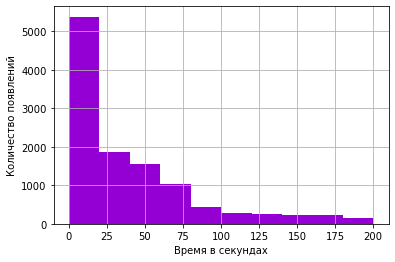

In [13]:
histos = train_data_10users[train_data_10users['session_timespan'] <= 200]['session_timespan'].hist(color='darkviolet')
histos.set_ylabel('Количество появлений')
histos.set_xlabel('Время в секундах')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0.5, 0, 'Количество уникальных сайтов в сессии')

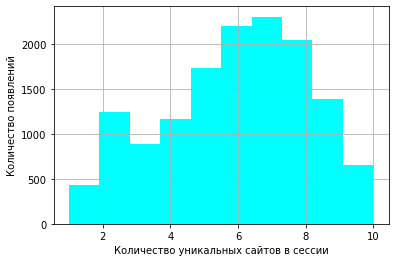

In [14]:
histos = train_data_10users['#unique_sites'].hist(color='aqua')
histos.set_ylabel('Количество появлений')
histos.set_xlabel('Количество уникальных сайтов в сессии')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

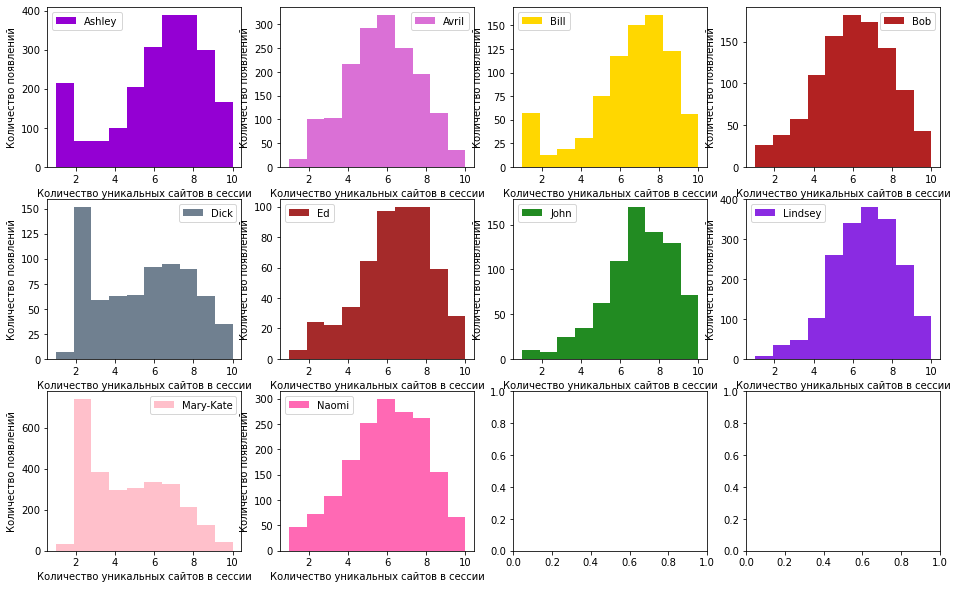

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx // 4][idx % 4].hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    axes[idx // 4][idx % 4].set_ylabel('Количество появлений')
    axes[idx // 4][idx % 4].set_xlabel('Количество уникальных сайтов в сессии')
    axes[idx // 4][idx % 4].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0.5, 0, 'Час начала сессии')

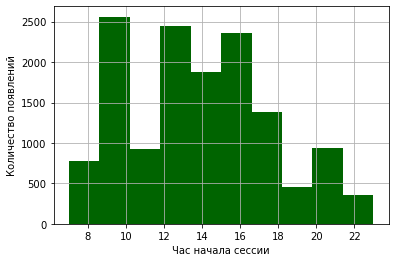

In [16]:
histos = train_data_10users['start_hour'].hist(color="darkgreen")
histos.set_ylabel('Количество появлений')
histos.set_xlabel('Час начала сессии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

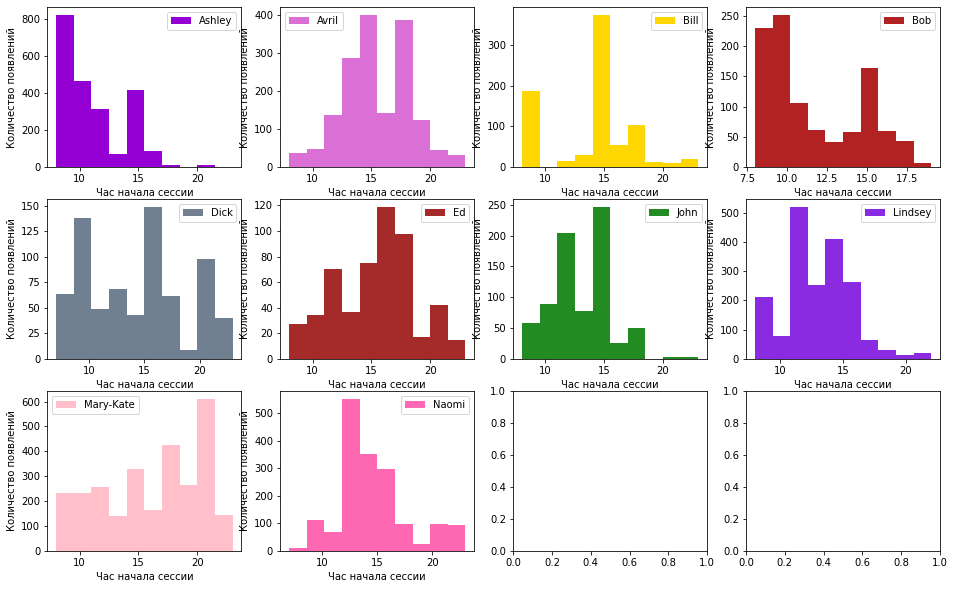

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx // 4][idx % 4].hist(sub_df['start_hour'], color=color_dic[user], label=user)
    axes[idx // 4][idx % 4].set_ylabel('Количество появлений')
    axes[idx // 4][idx % 4].set_xlabel('Час начала сессии')
    axes[idx // 4][idx % 4].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0.5, 0, 'День недели сессии')

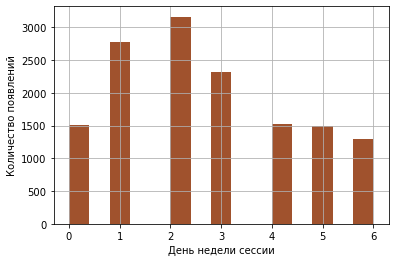

In [18]:
histos = train_data_10users['day_of_week'].hist(color="sienna", bins=15)
histos.set_ylabel('Количество появлений')
histos.set_xlabel('День недели сессии')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

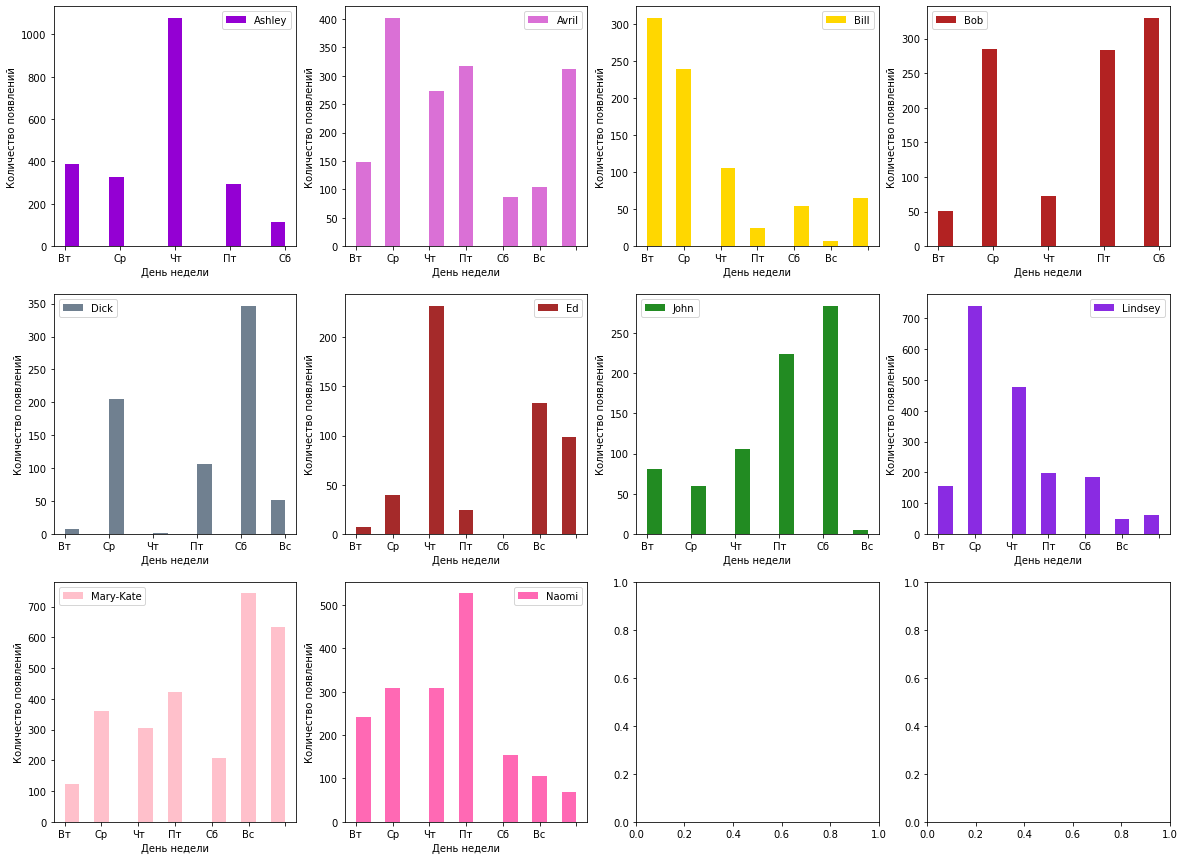

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    axes[idx // 4][idx % 4].hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins=15)
    axes[idx // 4][idx % 4].set_ylabel('Количество появлений')
    axes[idx // 4][idx % 4].set_xlabel('День недели')
    axes[idx // 4][idx % 4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx // 4][idx % 4].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Признаки: session_timespan, #unique_sites, start_hour, day_of_week

Из данных гистограмм можно сделать вывод, что пользователи Mary-Kate, Ashley, Bill, Dick в одной сесии либо посещают один-два сайта, либо сразу 6-7 сайтов. Все остальные гистограммы имеют нормальный вид, где пользователи в среднем посещают 5-6 сайтов.

Также, пользователи Ashley и Bob чаще всего начинают сессию с утра, Dick и Mary-Kate начинают сессию более менее равномерно в течении всего дня, остальные начинают сессию после полудня с 12 до 15 часов.

Ко всему прочему, Ashley и Ed чаще всего проводят сессии в четверг, Avrill, Bill, Lindsey, Naomi - в будние дни примерно равномерно много и мало в выходные, остальные - примерно одинаково в выходные и в будние дни.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [20]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), "rb") as openfile:
    sites = pickle.load(openfile)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [21]:
top10_sites = sorted(sites, key=lambda x: sites[x][1], reverse=True)[:10]
top10_freqs = list(map(lambda x: sites[x][1], top10_sites))

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

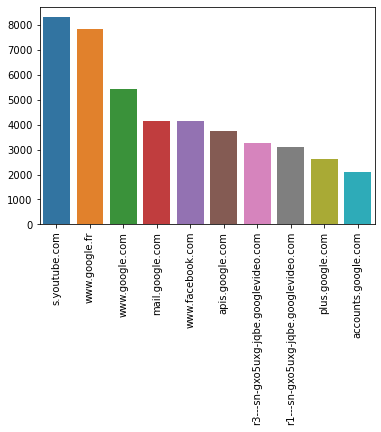

In [22]:
bar = sns.barplot(x=top10_sites, y=top10_freqs)
for item in bar.get_xticklabels():
    item.set_rotation(90)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [23]:
np.mean(np.array(train_data_10users['session_timespan']))

8369.030367683665

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [24]:
np.median(np.array(train_data_10users['day_of_week']))

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [25]:
np.median(np.array(train_data_150users['start_hour']))

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [26]:
np.median(np.array(train_data_150users['#unique_sites']))

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [27]:
def feature_engineering(path_to_csv_files, site_freq_path,
                                    session_length=10, window_size=10):
    files = glob(path_to_csv_files + '/*.csv')
    with open(site_freq_path, "rb") as openfile:
        sites = pickle.load(openfile)
    top30_sites = sorted(sites, key=lambda x: sites[x][1], reverse=True)[:30]
    top30_freqs = list(map(lambda x: sites[x][1], top30_sites))
    top30_coded = list(map(lambda x: sites[x][0], top30_sites))
    matrix = []
    names = ['month', 'avg_time_on_pop_sites', 'user_id']
    for i in files:
        id = int(i[-8:-4])
        frame = pd.read_csv(i)
        data_site = list(frame['site'])
        data_time = list(pd.to_datetime(frame['timestamp']))
        for j in range(len(data_site)):
            data_site[j] = sites[data_site[j]][0]
        a = math.ceil(len(data_site) / window_size)
        for s in range(a):
            length = 0
            part = data_site[window_size * s : window_size * s + session_length]
            part_time = data_time[window_size * s : window_size * s + session_length]
            k = 0
            for j in range(len(part) - 1):
                if part[j] in top30_coded:
                    delta = part_time[j + 1] - part_time[j]
                    length += delta.days * 3600 * 24 + delta.seconds
                    k += 1
            month = part_time[0].month
            if k == 0:
                avg = 0
            else:
                avg = length/k
            matrix.append([month, avg, id])
    return pd.DataFrame(matrix, columns=names,index=range(1, len(matrix) + 1))

In [28]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'))

CPU times: user 2.44 s, sys: 34 µs, total: 2.44 s
Wall time: 2.44 s


In [29]:
new_features_10users

,month,avg_time_on_pop_sites,user_id
1,11,7.833333,128
2,11,0.125000,128
3,11,0.285714,128
4,11,19.285714,128
5,11,14.000000,128
6,11,0.000000,128
7,11,0.000000,128
8,11,0.000000,128
9,11,0.000000,128
10,11,0.000000,128


In [30]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'))

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

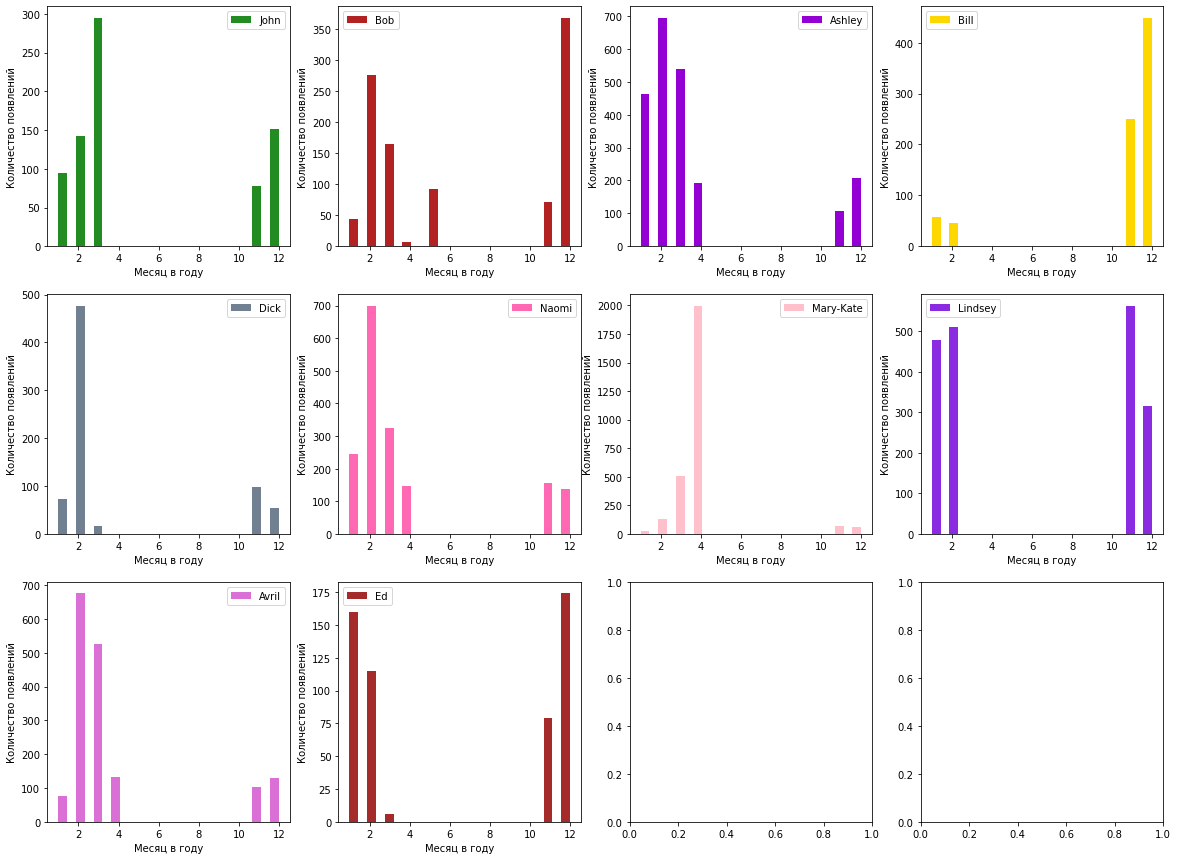

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    axes[idx // 4][idx % 4].hist(sub_df['month'], color=color_dic[id_name_dict[user]], label=id_name_dict[user], bins=25)
    axes[idx // 4][idx % 4].set_ylabel('Количество появлений')
    axes[idx // 4][idx % 4].set_xlabel('Месяц в году')
    axes[idx // 4][idx % 4].legend()

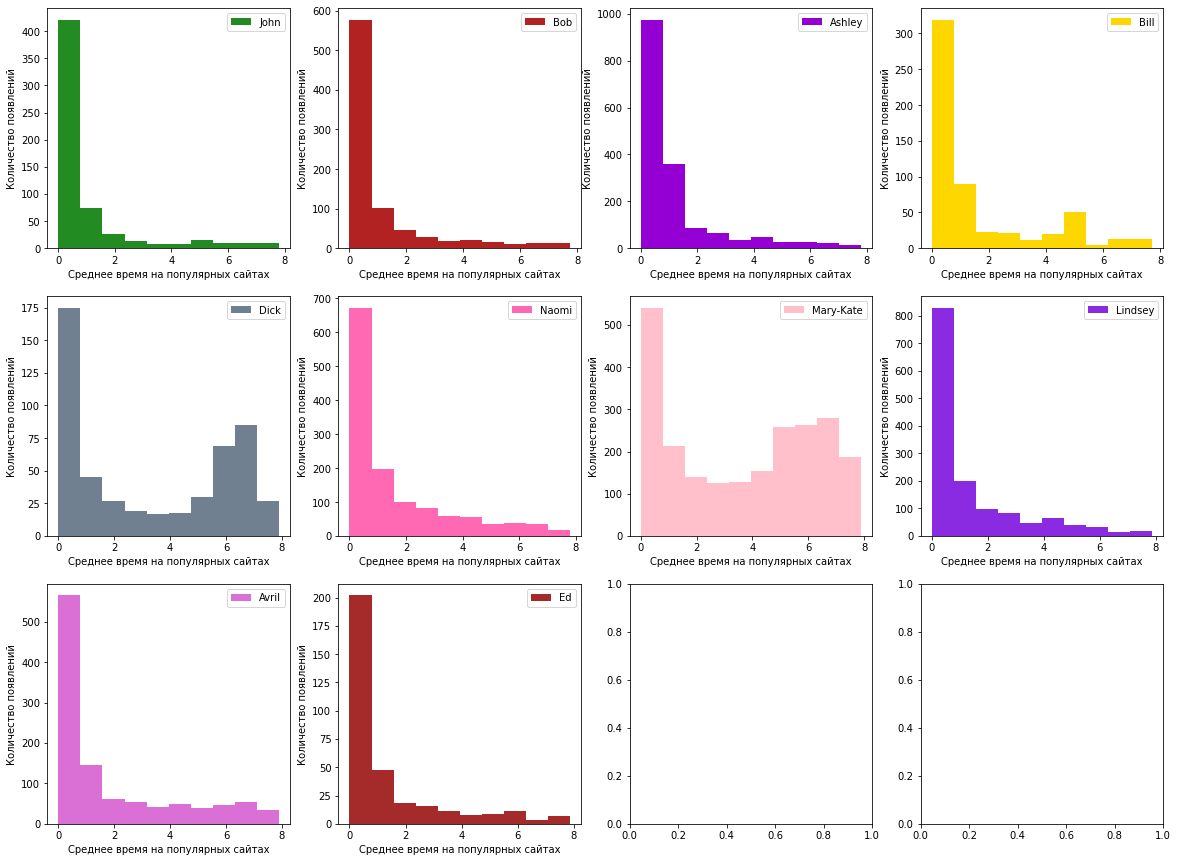

In [32]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    axes[idx // 4][idx % 4].hist(sub_df[sub_df['avg_time_on_pop_sites'] < 8]['avg_time_on_pop_sites'], color=color_dic[id_name_dict[user]], label=id_name_dict[user], bins=10)
    axes[idx // 4][idx % 4].set_ylabel('Количество появлений')
    axes[idx // 4][idx % 4].set_xlabel('Среднее время на популярных сайтах')
    axes[idx // 4][idx % 4].legend()

### Комментарий

Информация о месяце сессий дает нам довольно полезную информацию, в отличии от информации о среднем времени на популярных сайтах, так что включим в наш набор признаков только первый.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Возьмем признаки #unique_sites, start_hour, day_of_week и month так как по ним можно как то опредлеить непосредственного пользователя.

In [33]:
selected_features_10users = pd.concat([train_data_10users[np.hstack((train_data_10users.columns[:10], train_data_10users.columns[11:14]))], new_features_10users[np.hstack((new_features_10users.columns[0], new_features_10users.columns[2]))]], axis=1)

In [34]:
selected_features_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,#unique_sites,start_hour,day_of_week,month,user_id
1,1,2,3,4,5,2,6,7,7,2,7,13,4,11,128
2,4,5,6,2,8,9,10,8,10,9,7,13,4,11,128
3,11,10,11,9,4,2,2,12,13,10,7,13,4,11,128
4,10,12,10,9,10,2,2,13,2,2,5,13,4,11,128
5,14,15,15,16,16,11,12,14,15,15,5,13,4,11,128


In [35]:
selected_features_150users = pd.concat([train_data_150users[np.hstack((train_data_150users.columns[:10], train_data_150users.columns[11:14]))], new_features_150users[np.hstack((new_features_150users.columns[0], new_features_150users.columns[2]))]], axis=1)

In [36]:
selected_features_150users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,#unique_sites,start_hour,day_of_week,month,user_id
1,1,2,3,4,5,2,6,7,7,2,7,13,4,11,128
2,4,5,6,2,8,9,10,8,10,9,7,13,4,11,128
3,11,10,11,9,4,2,2,12,13,10,7,13,4,11,128
4,10,12,10,9,10,2,2,13,2,2,5,13,4,11,128
5,14,15,15,16,16,11,12,14,15,15,5,13,4,11,128


In [37]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 